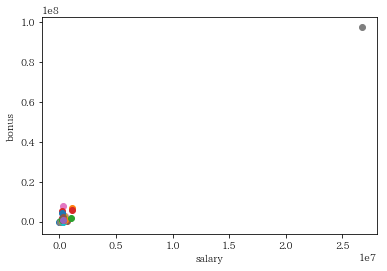

(18, ['CORDES WILLIAM R', 'LOWRY CHARLES P', 'CHAN RONNIE', 'WHALEY DAVID A', 'CLINE KENNETH W', 'LEWIS RICHARD', 'MCCARTY DANNY J', 'POWERS WILLIAM', 'PIRO JIM', 'WROBEL BRUCE', 'MCDONALD REBECCA', 'SCRIMSHAW MATTHEW', 'GATHMANN WILLIAM D', 'GILLIS JOHN', 'MORAN MICHAEL P', 'LOCKHART EUGENE E', 'SHERRICK JEFFREY B', 'FOWLER PEGGY', 'CHRISTODOULOU DIOMEDES', 'HUGHES JAMES A', 'HAYSLETT RODERICK J'])
GaussianNB(priors=None)
	Accuracy: 0.86293	Precision: 0.48103	Recall: 0.35500	F1: 0.40852	F2: 0.37463
	Total predictions: 15000	True positives:  710	False positives:  766	False negatives: 1290	True negatives: 12234



In [ ]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','bonus','total_payments','deferral_payments','deferred_income','director_fees','exercised_stock_options','expenses','from_messages','from_poi_to_this_person','from_this_person_to_poi','loan_advances','long_term_incentive','other','restricted_stock','restricted_stock_deferred','shared_receipt_with_poi','to_messages','total_payments','total_stock_value'] # You will need to use more features
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

data = featureFormat(data_dict, features_list)

### Task 2: Remove outliers
### Take outlier of salary and bonus
import numpy as np
import matplotlib.pyplot
### your code below
features = ['salary','bonus']
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

data_dict.pop("TOTAL",0)

data_dict['ALLEN PHILLIP K']['total_stock_value']
[k+":"+str(v['deferral_payments']) for k, v in data_dict.items()]

### Take outlier of totalpayment
### POI have totalpayment without Nan
features=["total_payments"]
data=featureFormat(data_dict, features)
n_POI_no_NAN=len([k+":"+str(v["total_payments"]) for k, v in data_dict.items() if (v["total_payments"] != 'NaN') & (v['poi'] == 1)])
l_name_NAN=[k for k, v in data_dict.items() if (v["total_payments"] == 'NaN')]
print(n_POI_no_NAN, l_name_NAN)

### ALL POI has total_payments without Nan. Therefore use average values.
for k in l_name_NAN:
    data_dict[k]['total_payments']=np.mean(data)

features=["salary"]
data=featureFormat(data_dict, features)
for k in l_name_NAN:
    data_dict[k]['salary']=np.mean(data)
features=["bonus"]
data=featureFormat(data_dict, features)
for k in l_name_NAN:
    data_dict[k]['bonus']=np.mean(data)

### Task 3: Create new feature(s)

def computeFraction( numerator, denominator ):    
    if (numerator=="NaN") or (denominator=="NaN"):
        fraction = 0.
    else:
        fraction = float(numerator) / float(denominator)
    return fraction
submit_dict = {}
for name in data_dict:
##calculate the fraction of messages to/from that personthat are from/to a POI
    data_point = data_dict[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    submit_dict[name]={"from_poi_to_this_person":fraction_from_poi,
                       "from_this_person_to_poi":fraction_to_poi}
    data_point["fraction_to_poi"] = fraction_to_poi
##calculate the fraction of salary/bonus that person
    total_payments = data_point["total_payments"]
    bonus = data_point["bonus"]
    salary = data_point["salary"]
    fraction_bonus = computeFraction(bonus, total_payments)
    fraction_salary = computeFraction(salary, total_payments)
    data_point["fraction_bonus"] = fraction_bonus
    data_point["fraction_salary"] = fraction_salary

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
sys.path.append("../tools/")
from sklearn.preprocessing import MinMaxScaler

# Feature Importance1(all values)
features_list = ['poi','salary','bonus','total_payments','deferral_payments','deferred_income','director_fees','exercised_stock_options','expenses','from_messages','from_poi_to_this_person','from_this_person_to_poi','loan_advances','long_term_incentive','other','restricted_stock','restricted_stock_deferred','shared_receipt_with_poi','to_messages','total_stock_value'] # You will need to use more features

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test =     train_test_split(features, labels, test_size=0.3, random_state=42)

clf_rf = RandomForestClassifier( n_estimators=100,max_depth=10)
clf_rf.fit(features_train, labels_train)

feature_importances = pd.DataFrame(clf_rf.feature_importances_,
                                   index = features_list[1:],
                                    columns = ['important']).sort_values('important',ascending = False)
feature_importances

#Check K value
from sklearn.feature_selection import SelectKBest
X, y = features, labels
kbest = SelectKBest()
kbest.fit(X, y)
kbest.get_params()

# Feature Importance2 from K value
features_list = ['poi','bonus','total_stock_value','exercised_stock_options','other','restricted_stock','deferred_income','expenses']#, 'long_term_incentive','salary','from_this_person_to_poi']#,'total_payments']

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test =     train_test_split(features, labels, test_size=0.3, random_state=42)

clf_rf = RandomForestClassifier()
clf_rf.fit(features_train, labels_train)


fti = clf_rf.feature_importances_   

feature_importances = pd.DataFrame(clf_rf.feature_importances_,
                                   index = features_list[1:],
                                    columns = ['important']).sort_values('important',ascending = False)
feature_importances


### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf1 = GaussianNB()
clf2 = RandomForestClassifier()
clf3= AdaBoostClassifier()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test =     train_test_split(features, labels, test_size=0.3, random_state=42)

clf1 = clf1.fit(features_train, labels_train)
test_classifier(clf1 ,my_dataset, features_list)
#clf2 = clf2.fit(features_train, labels_train)
#test_classifier(clf2 ,my_dataset, features_list)


### Try to tune some parameter for model
from sklearn.grid_search import GridSearchCV
parameters = {
    "n_estimators":[10,50,100],
}
#clf3 = GridSearchCV(clf3, parameters)
#clf3 = clf3.fit(features_train, labels_train)

test_classifier(clf3, my_dataset, features_list)


### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf1, my_dataset, features_list)